# Exploring AirBnB in Europe

A lot has been said and written about the effect of AirBnB around the world. In this assignment, you will use the data collected by [Inside AirBnB](http://insideairbnb.com).

Once you do that, spend some time familiarizing yourself with the data and then go ahead and do the following tasks. In the following questions, you will use data for the following cities:

* Amsterdam

* Athens

* Barcelona

* Berlin

* Copenhagen

* Dublin

* Lisbon

* London

* Madrid

* Paris

* Rome

* Venice

* Vienna

You will use the data for the latest 12 months period for which data is available.

We will use the **`ipywidgets`** library in this exercise, so if needed, uncomment the below cell and run it as well.

In [316]:
# pip install ipywidgets

## Data Loading and Preparation

In this section, we load Airbnb datasets for each city. 

The data includes:
  - **`Calendar Data`**: Booking Availability and pricing for each listing.
  - **`Listings Data`**: Metadata for each listing, including room type and location.
  - **`Neigbourhoods Data`**: Spatial boundaries of neigbourhoods.
  - **`Reviews Data`**: Guest reviews for individual listings.

The data is stored in a dictionary for efficient access and manipulation.

In [317]:
import os
import pandas as pd

import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import seaborn as sns

import ipywidgets as widgets

import warnings


In [318]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

In [319]:
cities = ["amsterdam", "athens", "barcelona", "berlin", "copenhagen", "dublin", "lisbon", "london", "madrid", "paris", "rome", "venice", "vienna"]

files = ["calendar.csv.gz", "listings.csv", "neighbourhoods.csv", "reviews.csv"]

# Path to the main data folder
data_path = "./data"

# Dictionary to hold data
data = {}

for city in cities:
    data[city] = {}
    city_folder = os.path.join(data_path, city)
    
    for file in files:
        file_path = os.path.join(city_folder, file)
        
        # Load the file into a DataFrame based on file extension and save to dictionary
        try:
            if file.endswith(".csv.gz"):
                data[city]["calendar"] = pd.read_csv(file_path, compression="gzip")
            else:
                key_name = f"{file.split('.')[0]}"  # Strip extension for consistent naming
                data[city][key_name] = pd.read_csv(file_path)
        except FileNotFoundError:
            print(f"Warning: {file_path} not found.")

## Data Cleaning and Preprocessing

Data often contains incinsistencies, missing values, or outliers. In this section, we will handle missing data by either imputing or removing rows/columns.

Preprocessing ensures that our analysis is accurate and meaningful.

In [320]:
data['athens']['listings'].head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,10595,"3 bedrooms, 2 bathrooms, 2nd floor with elevator",37177,Emmanouil,NaN,ΑΜΠΕΛΟΚΗΠΟΙ,37.98863,23.76527,Entire home/apt,108.0,1,52,2024-06-03,0.33,7,140,11,00002433180
1,10990,Athens Quality Apartments - Deluxe Apartment,37177,Emmanouil,NaN,ΑΜΠΕΛΟΚΗΠΟΙ,37.98903,23.76448,Entire home/apt,136.0,1,78,2024-04-30,0.54,7,158,13,00002433169
2,10993,Athens Quality Apartments - Studio,37177,Emmanouil,NaN,ΑΜΠΕΛΟΚΗΠΟΙ,37.98888,23.76473,Entire home/apt,67.0,1,96,2024-06-20,0.67,7,172,5,00002433010
3,10995,"AQA-No2 1-bedroom, smart tv, fiber connection,",37177,Emmanouil,NaN,ΑΜΠΕΛΟΚΗΠΟΙ,37.98903,23.76448,Entire home/apt,78.0,1,32,2024-03-09,0.19,7,142,2,00002433153
4,27262,Athens Quality Apartments - Ground floor apart...,37177,Emmanouil,NaN,ΑΜΠΕΛΟΚΗΠΟΙ,37.98924,23.76500,Entire home/apt,58.0,1,25,2024-01-13,0.17,7,172,4,00002433111


### **Handling Missing Values in the 'listings' Dataset**

Upon inspecting the `listings` dataset for each city, we identified several columns with missing or null values. Below is the plan for handling these missing values to ensure data consistency and reliability:

- **`neighbourhood_group`**  
  This column is often entirely or mostly null in many cities. To maintain consistency, we will replace all null values with a default placeholder. This allows us to handle missing entries systematically during later analyses.

- **`price`**  
  Some listings have missing values in the `price` column. Since pricing is a critical aspect of our analysis, we will replace these null values with a default value to prevent analysis disruptions, with plans for further adjustments as needed.

- **`reviews`**  
  Listings without reviews are expected, particularly for new entries. Null values in this column will be replaced with `0`, reflecting the absence of reviews.

- **`license`**  
  In some cities, the `license` column is sparsely populated or even entirely null. While this is a regulatory concern, for the purpose of our analysis, we will assign a default placeholder to all null entries. This will allow us to differentiate between listings with missing licenses and those with valid entries.

- **`host_name`**  
  Occasionally, the `host_name` column contains null values. Given the importance of this field for identifying and grouping hosts, and considering the low number of missing entries, we will replace null values with an empty string (`""`).

---

### **Summary of Actions**
- **Default placeholders** will be used for `neighbourhood_group`, `license`, and `price`.
- **Zeros** will be assigned to missing `reviews`.
- **Empty strings** will fill in for null `host_name` entries.

These preprocessing steps will ensure that our analysis remains robust and the data is ready for deeper exploration.

<Figure size 1400x800 with 0 Axes>

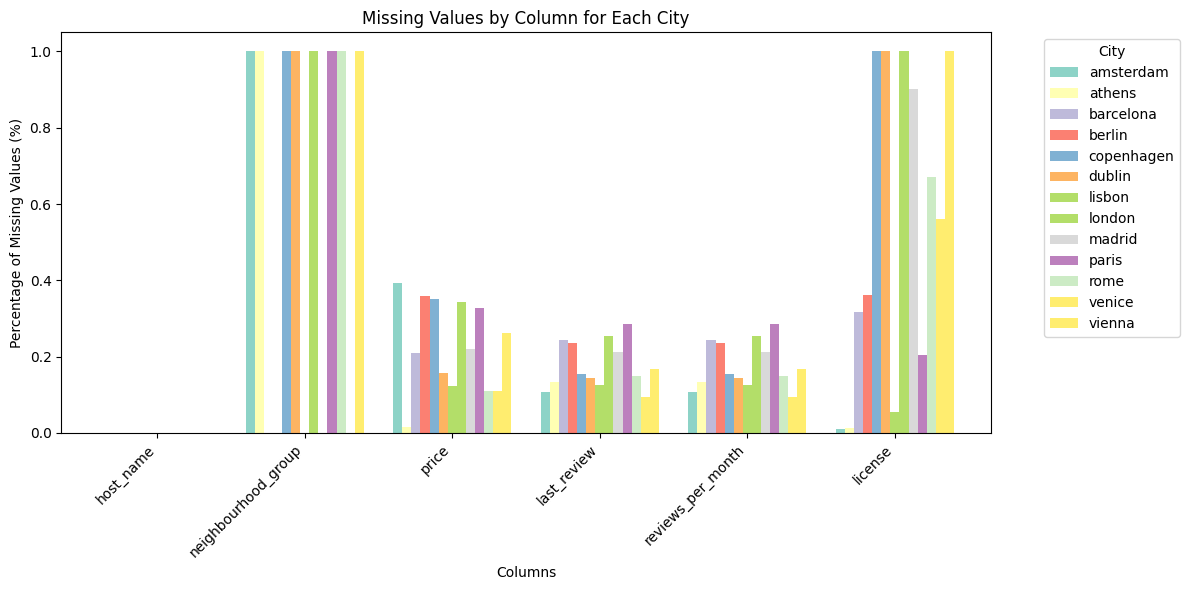

In [321]:
missing_data = {}

for city, datasets in data.items():    
    # Calculate percentage of missing values for each column
    missing_data[city] = datasets['listings'].isnull().mean()

# Convert to a DataFrame for easier plotting
missing_df = pd.DataFrame(missing_data)

# Filter out columns with no missing values in any city
missing_df = missing_df.loc[missing_df.sum(axis=1) > 0]

# Plotting
plt.figure(figsize=(14, 8))
missing_df.plot(kind='bar', width=0.8, figsize=(12, 6), colormap="Set3")
plt.ylabel("Percentage of Missing Values (%)")
plt.xlabel("Columns")
plt.title("Missing Values by Column for Each City")
plt.xticks(rotation=45, ha='right')
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [322]:
def clean_listings(data):
    data['neighbourhood_group'].fillna("", inplace=True)
    data['price'].fillna(0, inplace=True)
    data['number_of_reviews'].fillna(0, inplace=True)
    data['last_review'].fillna('0000-00-00', inplace=True)
    data['reviews_per_month'].fillna(0, inplace=True)
    data['license'].fillna("", inplace=True)
    data['host_name'].fillna("", inplace=True)
    
    return data

### Observations
We can see after the clean up of the listings datasets that there are no null values left. 

<Figure size 1400x800 with 0 Axes>

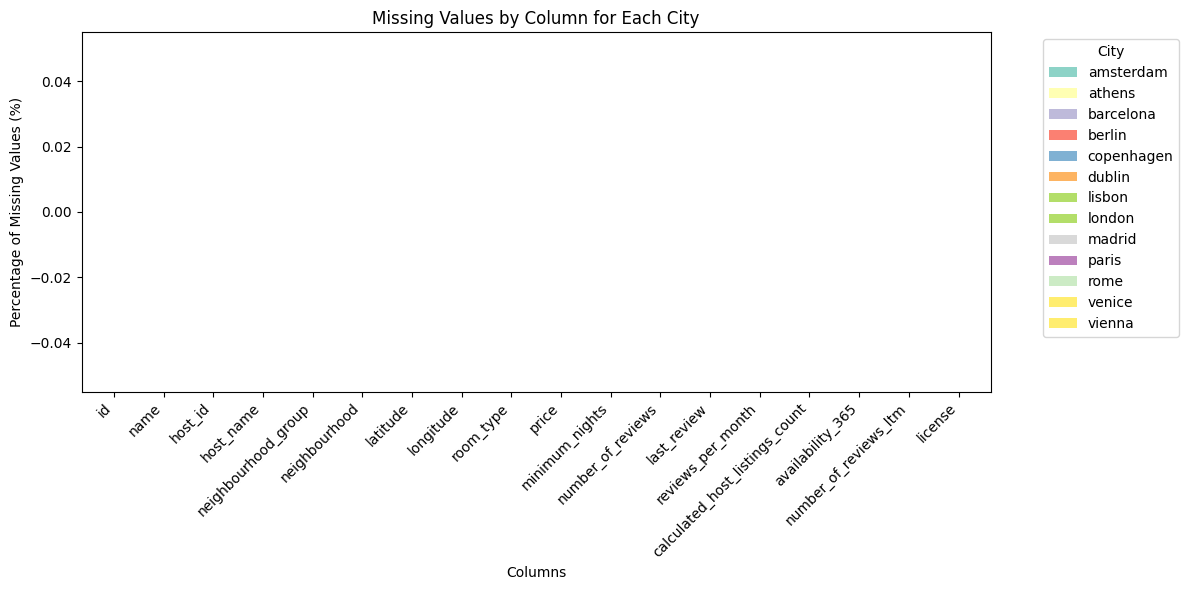

In [323]:
missing_data = {}

for city, datasets in data.items():
    datasets['listings'] = clean_listings(datasets['listings'])
    
    # Calculate percentage of missing values for each column
    missing_data[city] = datasets['listings'].isnull().mean()

# Convert to a DataFrame for easier plotting
missing_df = pd.DataFrame(missing_data)

# Plotting
plt.figure(figsize=(14, 8))
missing_df.plot(kind='bar', width=0.8, figsize=(12, 6), colormap="Set3")
plt.ylabel("Percentage of Missing Values (%)")
plt.xlabel("Columns")
plt.title("Missing Values by Column for Each City")
plt.xticks(rotation=45, ha='right')
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [324]:
data['athens']['reviews']

,listing_id,date
0,1154316,2013-06-28
1,3428808,2014-08-23
2,3428808,2014-08-28
3,3428808,2014-09-01
4,3428808,2014-09-08
...,...,...
688089,1176519625091585294,2024-06-14
688090,1176577066611811151,2024-06-15
688091,1176583371616472880,2024-06-24
688092,1176583684597030829,2024-06-24


### **Handling the `reviews` Dataset**

The `reviews` dataset has been examined, and we confirmed that it does not contain any null values. As a result, no preprocessing is necessary for this dataset. We will retain it in its original form for subsequent analyses. 

This ensures that the `reviews` data can be directly integrated into our workflows without any additional handling.

<Figure size 1400x800 with 0 Axes>

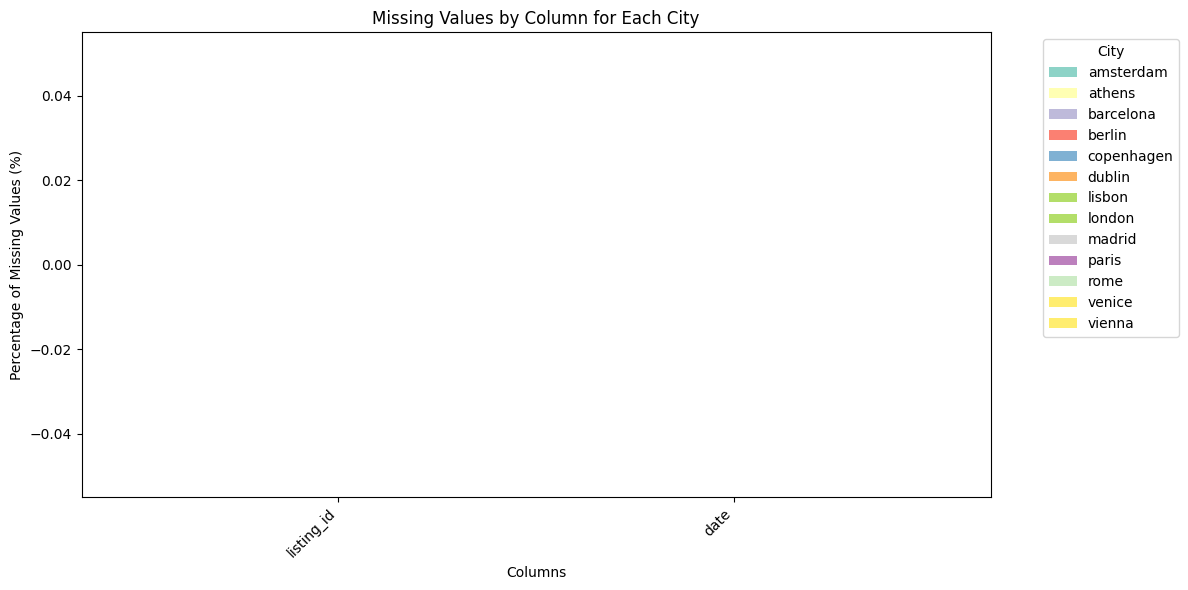

In [325]:
missing_data = {}

for city, datasets in data.items():    
    # Calculate percentage of missing values for each column
    missing_data[city] = datasets['reviews'].isnull().mean()

# Convert to a DataFrame for easier plotting
missing_df = pd.DataFrame(missing_data)

# Plotting
plt.figure(figsize=(14, 8))
missing_df.plot(kind='bar', width=0.8, figsize=(12, 6), colormap="Set3")
plt.ylabel("Percentage of Missing Values (%)")
plt.xlabel("Columns")
plt.title("Missing Values by Column for Each City")
plt.xticks(rotation=45, ha='right')
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [326]:
data['amsterdam']['calendar']

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,2818,2024-09-06,f,$69.00,NaN,3.0,1125.0
1,2818,2024-09-07,f,$69.00,NaN,3.0,1125.0
2,2818,2024-09-08,f,$69.00,NaN,3.0,1125.0
3,2818,2024-09-09,f,$69.00,NaN,3.0,1125.0
4,2818,2024-09-10,t,$69.00,NaN,3.0,1125.0
...,...,...,...,...,...,...,...
3525169,1238449706748135184,2025-09-01,t,$280.00,NaN,1.0,365.0
3525170,1238449706748135184,2025-09-02,t,$280.00,NaN,1.0,365.0
3525171,1238449706748135184,2025-09-03,t,$280.00,NaN,1.0,365.0
3525172,1238449706748135184,2025-09-04,t,$280.00,NaN,1.0,365.0


### **Handling Missing Values in the `calendar` Dataset**

Upon reviewing the `calendar` dataset, we found the following columns with missing values:

- **`adjusted_price`**  
  The `adjusted_price` column frequently contains null values. For consistency in our calculations, we will replace each null entry with `0`. This will allow us to seamlessly handle price-related analyses.

- **`maximum_nights`** and **`minimum_nights`**  
  These columns occasionally have null values. To ensure data integrity and facilitate analysis, we will replace all null entries in both columns with `0`.

By applying these replacements, we can maintain a complete and coherent dataset for our analysis.

<Figure size 1400x800 with 0 Axes>

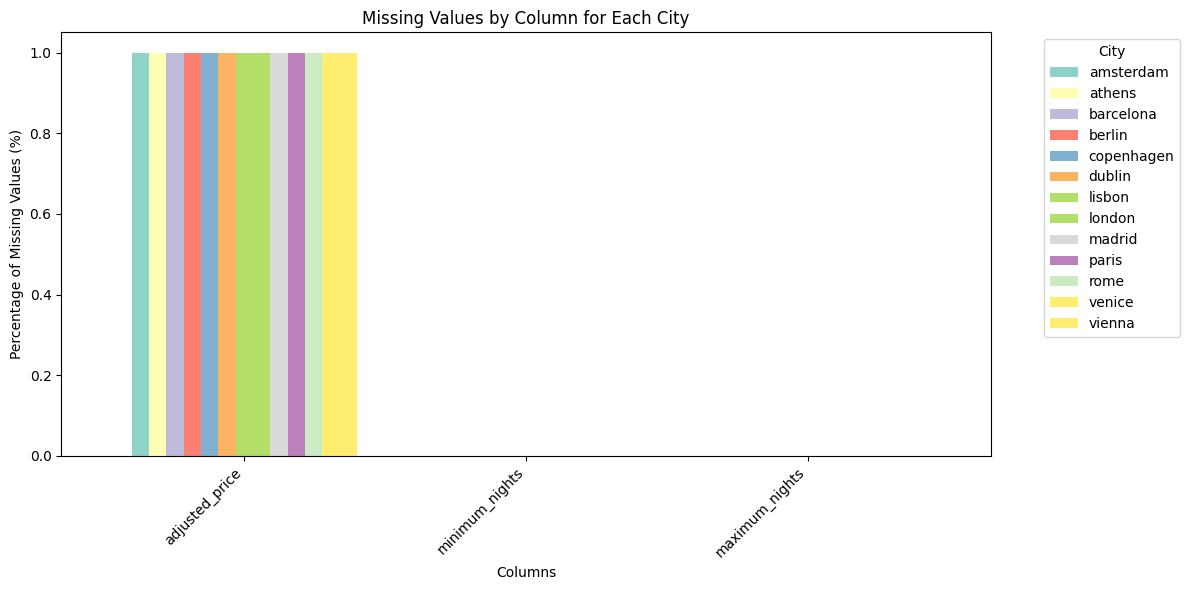

In [327]:
missing_data = {}

for city, datasets in data.items():    
    # Calculate percentage of missing values for each column
    missing_data[city] = datasets['calendar'].isnull().mean()

# Convert to a DataFrame for easier plotting
missing_df = pd.DataFrame(missing_data)

# Filter out columns with no missing values in any city
missing_df = missing_df.loc[missing_df.sum(axis=1) > 0]

# Plotting
plt.figure(figsize=(14, 8))
missing_df.plot(kind='bar', width=0.8, figsize=(12, 6), colormap="Set3")
plt.ylabel("Percentage of Missing Values (%)")
plt.xlabel("Columns")
plt.title("Missing Values by Column for Each City")
plt.xticks(rotation=45, ha='right')
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [328]:
def clean_calendar(data):
    data['adjusted_price'].fillna(0, inplace=True)
    data['minimum_nights'].fillna(0, inplace=True)
    data['maximum_nights'].fillna(0, inplace=True)
    
    return data

<Figure size 1400x800 with 0 Axes>

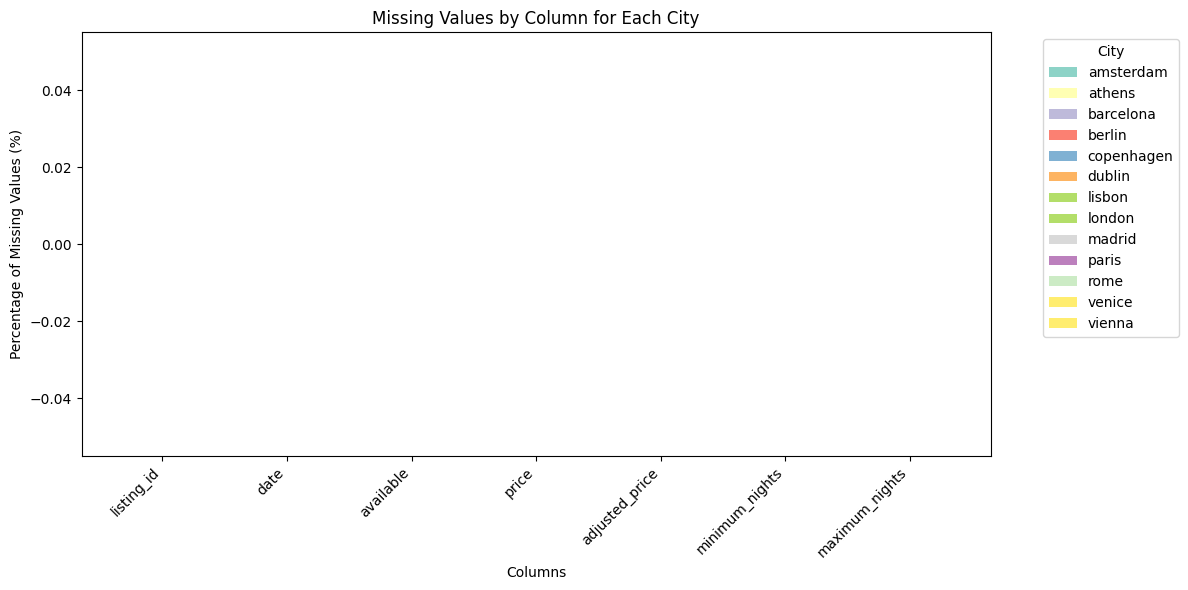

In [329]:
missing_data = {}

for city, datasets in data.items():    
    datasets['calendar'] = clean_calendar(datasets['calendar'])

    # Calculate percentage of missing values for each column
    missing_data[city] = datasets['calendar'].isnull().mean()

# Convert to a DataFrame for easier plotting
missing_df = pd.DataFrame(missing_data)

# Plotting
plt.figure(figsize=(14, 8))
missing_df.plot(kind='bar', width=0.8, figsize=(12, 6), colormap="Set3")
plt.ylabel("Percentage of Missing Values (%)")
plt.xlabel("Columns")
plt.title("Missing Values by Column for Each City")
plt.xticks(rotation=45, ha='right')
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


### **Observations**

After cleaning the `calendar` datasets by addressing the missing values in the `adjusted_price`, `maximum_nights`, and `minimum_nights` columns, we confirmed that there are no null values remaining. 

This ensures that the `calendar` datasets are now fully prepared for analysis without any missing data issues.

In [330]:
data['venice']['neighbourhoods']

,neighbourhood_group,neighbourhood
0,Isole,Alberoni
1,Isole,Burano
2,Isole,Cannaregio
3,Isole,Castello
4,Isole,Dorsoduro
...,...,...
109,Terraferma,Villabona
110,Terraferma,Villaggio San Marco
111,Terraferma,Villaggio Sartori
112,Terraferma,Zelarino


### **Handling Missing Values in the `neighbourhoods` Dataset**

The `neighbourhoods` dataset presents two primary issues with missing values:

- **`neighbourhood_group`**  
  This column is frequently empty. To standardize the data and simplify our processing, we will replace each empty entry with an empty string (`""`).

- **`neighbourhood`**  
  This column is critical as it contains key information about the specific neighborhoods. Unfortunately, there are null values in this column. Given the importance of this data, we will **remove any rows where the `neighbourhood` value is null or empty** to ensure the integrity of our analysis.

By taking these steps, we ensure that the dataset remains clean and reliable for our subsequent analyses.

<Figure size 1400x800 with 0 Axes>

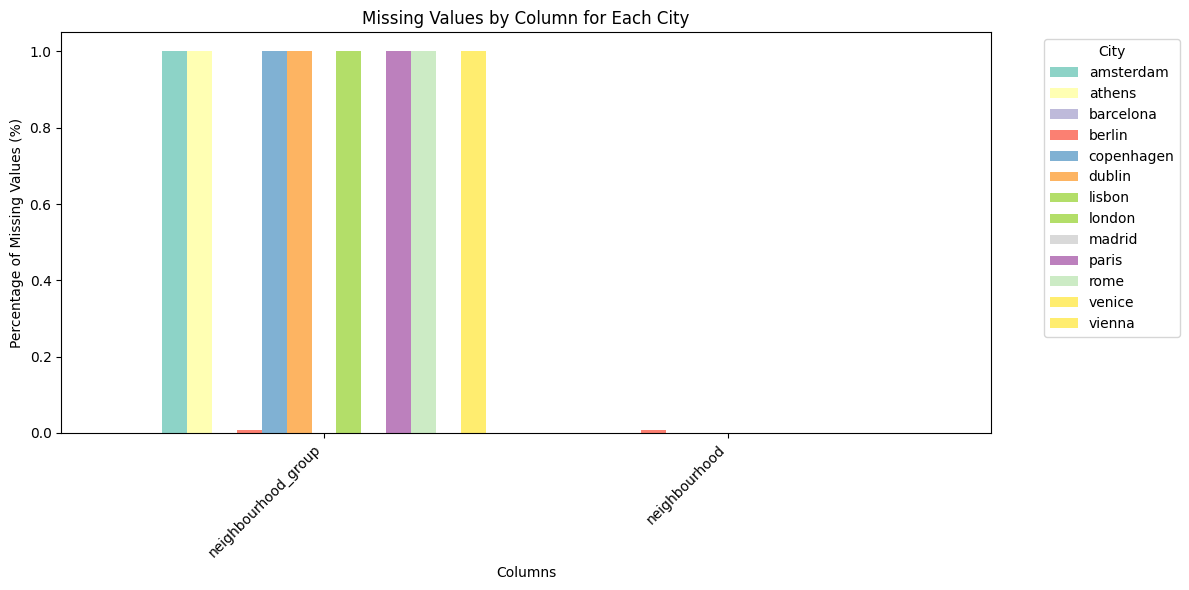

In [331]:
missing_data = {}

for city, datasets in data.items():    
    # Calculate percentage of missing values for each column
    missing_data[city] = datasets['neighbourhoods'].isnull().mean()

# Convert to a DataFrame for easier plotting
missing_df = pd.DataFrame(missing_data)

# Filter out columns with no missing values in any city
missing_df = missing_df.loc[missing_df.sum(axis=1) > 0]

# Plotting
plt.figure(figsize=(14, 8))
missing_df.plot(kind='bar', width=0.8, figsize=(12, 6), colormap="Set3")
plt.ylabel("Percentage of Missing Values (%)")
plt.xlabel("Columns")
plt.title("Missing Values by Column for Each City")
plt.xticks(rotation=45, ha='right')
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [332]:
def clean_neighbourhoods(data):
    data['neighbourhood_group'].fillna("", inplace=True)
    data.dropna(subset=['neighbourhood'], inplace=True)
        
    return data

<Figure size 1400x800 with 0 Axes>

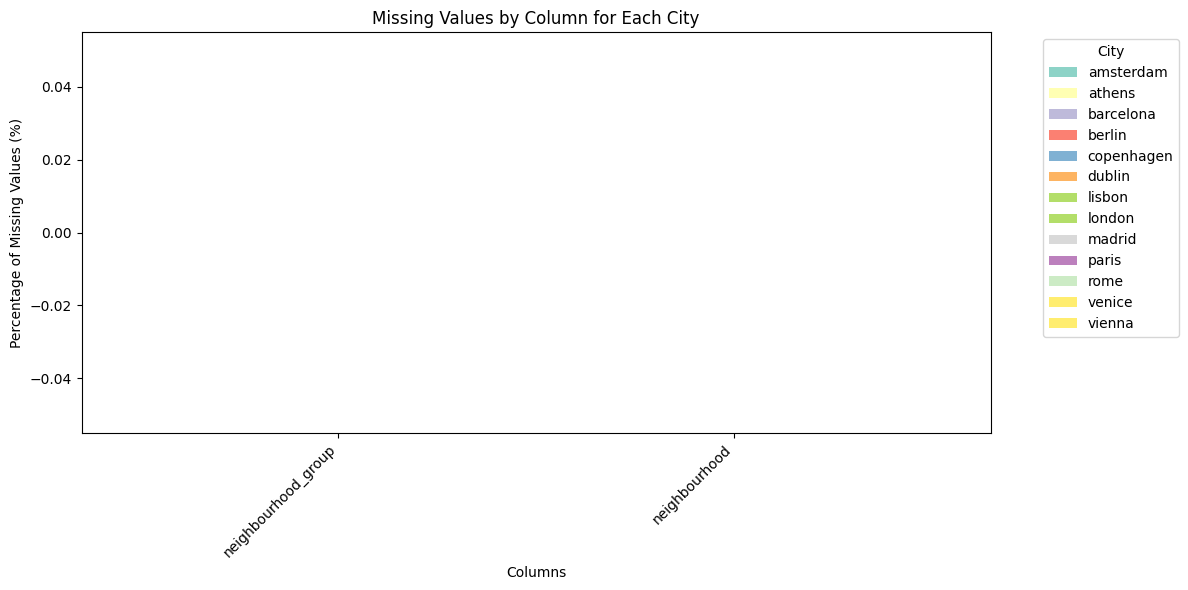

In [333]:
missing_data = {}

for city, datasets in data.items(): 
    datasets['neighbourhoods'] = clean_neighbourhoods(datasets['neighbourhoods'])
   
    # Calculate percentage of missing values for each column
    missing_data[city] = datasets['neighbourhoods'].isnull().mean()

# Convert to a DataFrame for easier plotting
missing_df = pd.DataFrame(missing_data)

# Plotting
plt.figure(figsize=(14, 8))
missing_df.plot(kind='bar', width=0.8, figsize=(12, 6), colormap="Set3")
plt.ylabel("Percentage of Missing Values (%)")
plt.xlabel("Columns")
plt.title("Missing Values by Column for Each City")
plt.xticks(rotation=45, ha='right')
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


### **Observations**

After cleaning the `neighbourhoods` datasets by addressing the missing values in the `neighbourhood_group`, and `neighbourhood` columns, we confirmed that there are no null values remaining. 

This ensures that the `neighbourhoods` datasets are now fully prepared for analysis without any missing data issues.

## AirBnB Listings

Find the number of AirBnB listings per city. Show the information in tabular format, and also make a plot.

In [334]:
no_listings_per_city = {}

In [335]:
# Find the total amount of listings per city
for city, datasets in data.items():
    no_listings_per_city[city] = len(datasets['listings'])

In [336]:
listings_per_city_df = pd.DataFrame(list(no_listings_per_city.items()), columns=['City', 'Listings'])
listings_per_city_df = listings_per_city_df.sort_values(by='Listings', ascending=False)

print("Number of AirBnb Listings per City:")
listings_per_city_df

Number of AirBnb Listings per City:


,City,Listings
7,london,96182
9,paris,95461
10,rome,34061
8,madrid,26980
6,lisbon,24204
4,copenhagen,20909
2,barcelona,19482
12,vienna,14396
3,berlin,13759
1,athens,13274


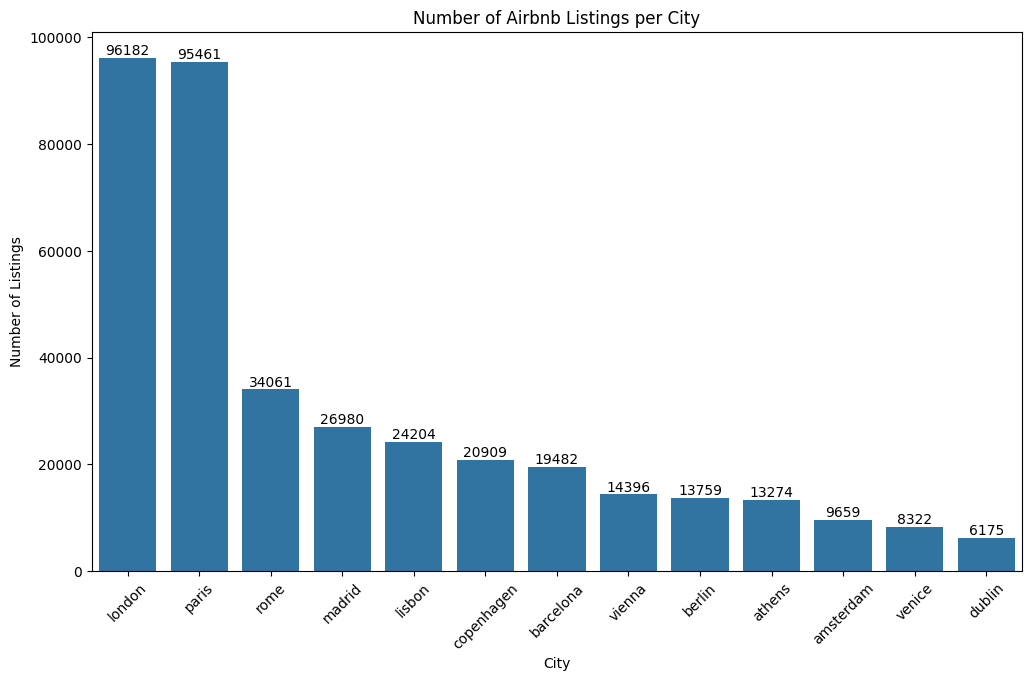

In [337]:
plt.figure(figsize=(12, 7))
plt.xlabel('City')
plt.ylabel('Number of Listings')
plt.title('Number of Airbnb Listings per City')
plt.xticks(rotation=45)
ax = sns.barplot(listings_per_city_df, x="City", y="Listings", estimator="sum")
ax.bar_label(ax.containers[0], fontsize=10)

plt.show()

### **Observations**
This list closely resembles the official ["Most visited cities in Europe"](https://thesavvybackpacker.com/most-visited-cities-in-europe/). When a city attracts a large number of tourists, its economy is heavily influenced by the demand for accommodations. This helps explain why the most popular tourist destinations often have the highest number of Airbnb listings. 

One really interesting observation, is that even though Amsterdam has a lot more tourists visiting each year, Madrid holds more than twice the amount of Airbnb listings. This can be related to:
1. **`Regulatory Differences`**: Amsterdam has implemented strict regulations on short-term rentals, including Airbnb. These rules limit the number of days properties can be rented out each year, require registration, and impose fines for non-compliance. Madrid, on the other hand, has generally had more lenient regulations, allowing more listings to flourish.

2. **`Availability of Residential Space`**: Madrid is a larger city in terms of land area, offering more residential space where Airbnb listings can be hosted. This greater space might contribute to a higher number of listings compared to the more compact Amsterdam.

3. **`Local Demand and Usage`**: In addition to international tourists, Madrid's Airbnb market may also cater to domestic tourists or long-term stays, as it’s a popular destination within Spain. This broader usage could contribute to a higher overall number of listings.

4. **`Tourism Preferences`**: Amsterdam has a higher proportion of traditional hotel accommodations compared to Madrid. Many tourists may prefer the established hotel sector in Amsterdam, while in Madrid, visitors may be more inclined to book alternative accommodations, like AirBnb, especially if they're seeking a local experience or longer stays.

## AirBnB Densities

Apart from the number of distinct listings, we are interested in the density, that is, the number of AirBnB listings per 1,000 inhabitants, again for the latest 12 months period for which data is available. You must determine the number of inhabitants per city in the most appropriate way. Show the information in tabular format, and also make a plot.

### **Population of Selected Cities (2024)**

The table below presents the population of various cities as of 2024, based on data sourced from [World Population Review](https://worldpopulationreview.com/) and additional resources.

| City          | Population | Source |
|---------------|------------|--------|
| Athens        | 643,452    | [Wikipedia - Δήμος Αθηναίων](https://el.wikipedia.org/wiki/Κατάλογος_δήμων_της_Ελλάδας) |
| Amsterdam     | 1,181,820  | [World Population Review](https://worldpopulationreview.com/cities/netherlands/amsterdam) |
| Barcelona     | 5,711,920  | [World Population Review](https://worldpopulationreview.com/cities/spain/barcelona) |
| Berlin        | 3,576,870  | [World Population Review](https://worldpopulationreview.com/cities/germany/berlin) |
| Copenhagen    | 1,391,200  | [World Population Review](https://worldpopulationreview.com/) |
| Dublin        | 1,284,550  | [World Population Review](https://worldpopulationreview.com/) |
| Lisbon        | 3,014,610  | [World Population Review](https://worldpopulationreview.com/) |
| London        | 9,748,030  | [World Population Review](https://worldpopulationreview.com/) |
| Madrid        | 3,286,080  | [World Population Review](https://worldpopulationreview.com/cities/spain/madrid) |
| Paris         | 11,319,000 | [World Population Review](https://worldpopulationreview.com/cities/france/paris) |
| Rome          | 2,870,337  | [World Population Review](https://worldpopulationreview.com/cities/italy/rome) |
| Venice        | 261,905    | [World Population Review](https://worldpopulationreview.com/) |
| Vienna        | 2,014,000  | [World Population Review](https://worldpopulationreview.com/cities/austria/vienna) |

*Note*: Population figures are approximate and reflect the most recent available data for each city.


In [338]:
city_population = {
    "athens": 643452,
    "amsterdam": 1181820,
    "barcelona": 5711920,
    "berlin": 3576870,
    "copenhagen": 1391200,
    "dublin": 1284550,
    "lisbon": 3014610,
    "london": 9748030,
    "madrid": 3286080,
    "paris": 11319000,
    "rome": 2870337,
    "venice": 261905,
    "vienna": 2014000
}


In [339]:
density_per_city = no_listings_per_city

In [340]:
density_per_city_df = pd.DataFrame(list(density_per_city.items()), columns=['City', 'Listings'])

density_per_city_df["Population"] = density_per_city_df["City"].map(city_population)
density_per_city_df["Density"] = density_per_city_df["Listings"] / (density_per_city_df["Population"] / 1000)

density_per_city_df = density_per_city_df.sort_values(by='Density', ascending=False)

In [341]:
print('Each City and its Population and its Density by 1,000 Inhabitants:')
density_per_city_df

Each City and its Population and its Density by 1,000 Inhabitants:


,City,Listings,Population,Density
11,venice,8322,261905,31.774880
1,athens,13274,643452,20.629355
4,copenhagen,20909,1391200,15.029471
10,rome,34061,2870337,11.866551
7,london,96182,9748030,9.866814
9,paris,95461,11319000,8.433696
8,madrid,26980,3286080,8.210390
0,amsterdam,9659,1181820,8.172987
6,lisbon,24204,3014610,8.028899
12,vienna,14396,2014000,7.147964


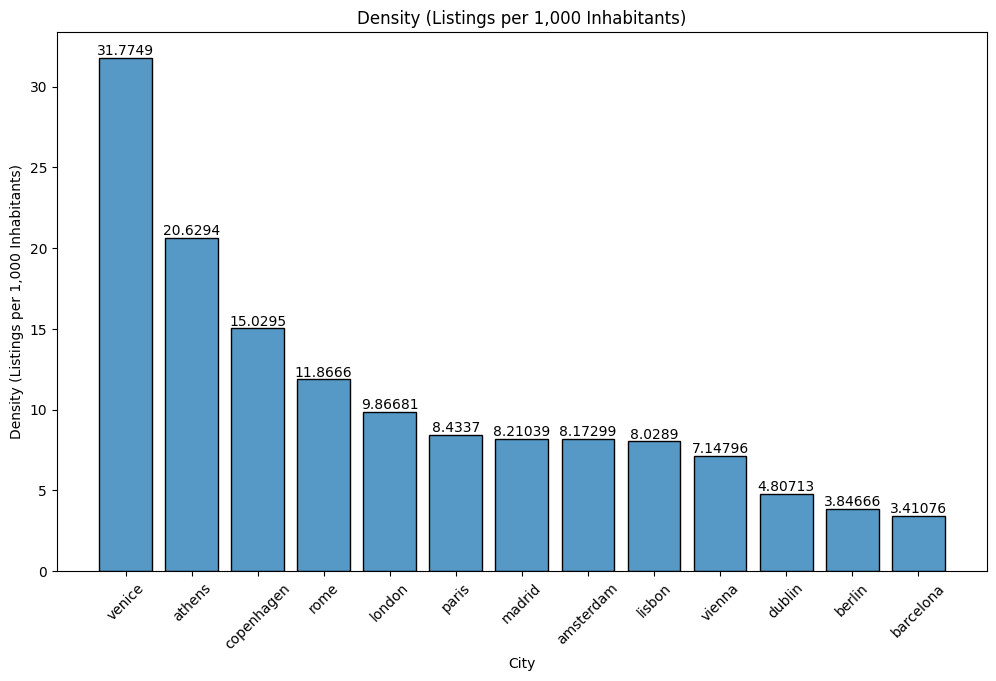

In [342]:
plt.figure(figsize=(12, 7))
plt.xlabel('City')
plt.ylabel('Density (Listings per 1,000 Inhabitants)')
plt.title('Density (Listings per 1,000 Inhabitants)')
plt.xticks(rotation=45)

ax = sns.histplot(
    data=density_per_city_df, 
    x="City", 
    weights="Density", 
    shrink=0.8, 
)
ax.bar_label(ax.containers[0], fontsize=10)

plt.show()

### **Observations**
We observe that Venice has the highest number of AirBnb listings per 1,000 inhabitants. This is likely due to its small land area, consisting primarily of one main island and several smaller ones. As a major tourist destination, Venice experiences high demand for short-term accommodations. The combination of limited residential space and a strong tourism industry contributes to the high density of Airbnb listings relative to the population.

The city with the second-highest density of AirBnb listings is Athens. This is likely because Athens' historic old town and central area are relatively small in size but attract significant tourism each year. The high concentration of visitors in a compact area creates a strong demand for accommodations, leading to a high density of AirBnb listings per 1,000 residents.

## Activity

We are interested in the AirBnB bookings and income per listing for each city. Calculate, for each city, the average number of nights a listing is booked, by assuming that half of the bookings have reviews, and that each booking is for three nights. Use the number of reviews for the last 12 months for each listing. To calculate the income per listing, multiply the price of each listing by the number of nights you have calculated for the listing. Then, find the average of the income per listing for each city.

In [343]:
# Initialize dictionaries to store results
avg_nights_booked = {}
avg_income = {}

for city, datasets in data.items():
    listings_df = datasets['listings']

    # We calulate the information we need by assuming that half of the bookings have reviews, 
    # and that each booking is for three nights.
    listings_df['total_bookings'] = listings_df['number_of_reviews_ltm'] * 2
    listings_df['total_nights_booked'] = listings_df['total_bookings'] * 3
    listings_df['income_per_listing'] = listings_df['price'] * listings_df['total_nights_booked']

    avg_nights_booked[city] = listings_df['total_nights_booked'].mean()
    avg_income[city] = listings_df['income_per_listing'].mean()

avg_nights_booked_df = pd.DataFrame(list(avg_nights_booked.items()), columns=['City', 'Average Nights Booked'])
avg_nights_booked_df = avg_nights_booked_df.sort_values(by='Average Nights Booked', ascending=False)

avg_income_per_listing_df = pd.DataFrame(list(avg_income.items()), columns=['City', 'Average Income per Listing'])
avg_income_per_listing_df = avg_income_per_listing_df.sort_values(by='Average Income per Listing', ascending=False)

In [344]:
print("Average Nights Booked per Listing for Each City last 12 months:")
avg_nights_booked_df

Average Nights Booked per Listing for Each City last 12 months:


,City,Average Nights Booked
11,venice,117.676280
10,rome,88.730278
6,lisbon,87.708478
1,athens,86.318819
5,dublin,85.344777
8,madrid,84.971831
2,barcelona,71.434863
12,vienna,69.296749
0,amsterdam,56.225075
3,berlin,53.600116


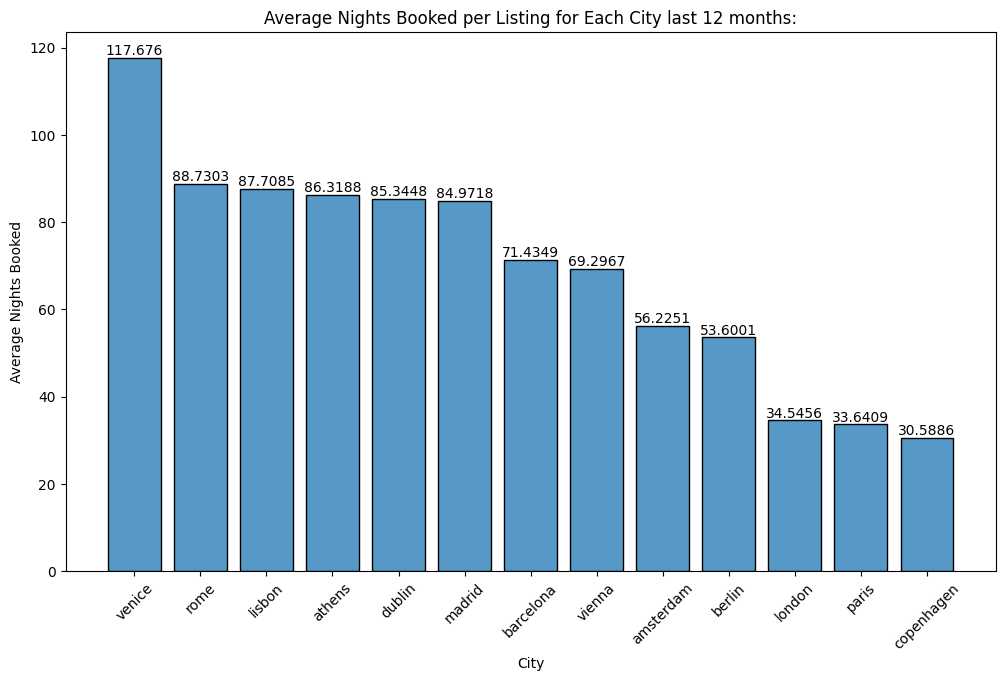

In [345]:
plt.figure(figsize=(12, 7))
plt.xlabel('City')
plt.ylabel('Average Nights Booked')
plt.title('Average Nights Booked per Listing for Each City last 12 months:')
plt.xticks(rotation=45)

# Use histplot to display the data with side-by-side bars for each city
ax = sns.histplot(
    data=avg_nights_booked_df, 
    x="City", 
    weights="Average Nights Booked", 
    shrink=0.8, 
)

ax.bar_label(ax.containers[0], fontsize=10)


plt.show()

### **Observations**
From the data on average nights booked per Airbnb listing in various cities over the last 12 months, notable differences in occupancy rates across popular European destinations are observed. `Venice` stands out with the highest average, around 117 nights booked per listing, reflecting its intense seasonal tourism and event-driven demand, such as during the Venice Film Festival. Similarly, cities like `Rome`, `Lisbon`, and `Athens` follow closely, each with over 85 nights booked on average, aligning with their strong year-round appeal to international visitors and fewer restrictions on short-term rentals. `Dublin` and `Madrid` also maintain moderate booking rates, benefiting from their robust tourism sectors, with an average above 80 nights per listing.

In contrast, other major cities, including `Barcelona` and `Vienna`, fall to lower averages, around 70 nights, still reflecting steady but less intense demand compared to the top cities. Surprisingly, cities like `Amsterdam`, `Berlin`, `London`, and `Paris`, despite being globally renowned travel destinations, report lower average bookings, with Paris and London particularly low at around 34 nights. This discrepancy can be attributed to strict regulatory environments, where cities like `Amsterdam` and `Berlin` impose caps on short-term rental nights to manage local housing markets, which likely affects overall occupancy. Additionally, Paris and London have the highest number of listings, which leads to more spread-out bookings across a larger pool of properties, thereby resulting in lower average bookings per listing.

`Copenhagen` has the lowest average with just over 30 nights, potentially due to its smaller tourism base or higher relative supply of listings. In summary, the data suggests that tourism demand, combined with local regulations, market dynamics, and listing saturation, plays a critical role in shaping Airbnb occupancy rates across these cities.

In [346]:
print("Average Income per Listing for Each City last 12 months:")
avg_income_per_listing_df

Average Income per Listing for Each City last 12 months:


,City,Average Income per Listing
4,copenhagen,32739.805634
11,venice,23220.188897
10,rome,15307.892252
2,barcelona,13429.283646
5,dublin,13082.099757
6,lisbon,11600.070897
0,amsterdam,10029.903510
8,madrid,9872.146256
1,athens,8659.512882
3,berlin,7564.293626


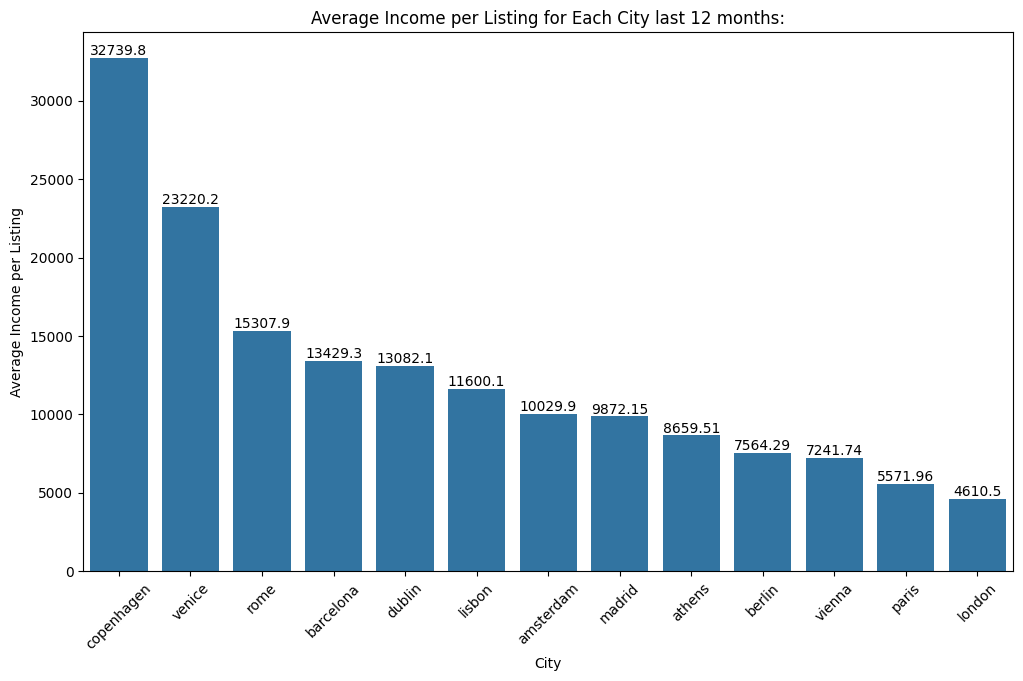

In [347]:
plt.figure(figsize=(12, 7))
plt.xlabel('City')
plt.ylabel('Average Income per Listing')
plt.title('Average Income per Listing for Each City last 12 months:')
plt.xticks(rotation=45)
ax = sns.barplot(avg_income_per_listing_df, x="City", y="Average Income per Listing", errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10)

plt.show()

### **Observations**
The data on average income per Airbnb listing over the past 12 months reveals some surprising trends, particularly when compared to average nights booked. `Copenhagen`, which had the lowest occupancy with only 30 nights per year, actually reports the highest average income per listing at approximately $32,740. This discrepancy suggests that Copenhagen’s listings command significantly higher nightly rates, compensating for the low booking frequency and likely reflecting a luxury-oriented or high-price market. Meanwhile, `Venice`, which led in occupancy with an average of 117 nights booked, shows a considerably lower average income of around $23,220. This suggests a more modest nightly rate in Venice despite the high demand, possibly due to a wider range of budget accommodation options catering to seasonal tourists.

`Rome`, `Barcelona`, and `Dublin` follow, with each listing earning between $13,000 and $15,000 on average. Although they rank highly in both occupancy and income, their incomes are noticeably lower than Copenhagen’s, reflecting the impact of more competitive pricing or broader availability of mid-range options. `Lisbon`, `Amsterdam`, and `Madrid` exhibit moderate incomes, around $10,000 to $11,000 per listing, consistent with their steady but lower booking averages and indicating a balanced price point in these markets.

Interestingly, globally recognized tourist hubs like `Paris` and `London` report the lowest average incomes at around $5,570 and $4,610, respectively. Given Paris’s low occupancy rate (33 nights) and strict regulatory limits, this lower income aligns with reduced rental opportunities. London’s income may similarly suffer from high competition among listings, regulatory caps, or market saturation. In summary, while cities like Copenhagen can sustain high earnings per listing through premium rates despite low occupancy, other destinations rely on steady bookings to drive income, highlighting the complex interaction of nightly rates, demand, and local regulations across these cities.

We can also highlight here the impact of the more dispersed distribution of listings, which likely plays a significant role in the lower average bookings observed for larger cities like London and Paris.

## Cross-check

Find the total number of bookings and nights spent over the last 12 months period for which you have data, for each of the cities. Then compare your findings with publicly available data. Explain how you sourced the data, the methodology that has been used for their collection, and your assessment of their quality. Discuss any differences from your own results.

In [348]:
# Initialize dictionaries to store results
total_bookings_per_city = {}
total_nights_per_city = {}

for city, datasets in data.items():
    listings_df = datasets['listings']

    total_bookings_per_city[city] = listings_df['total_bookings'].sum()
    total_nights_per_city[city] = listings_df['income_per_listing'].sum()

total_bookings_per_city_df = pd.DataFrame(list(total_bookings_per_city.items()), columns=['City', 'Total Bookings last 12 months'])
total_bookings_per_city_df = total_bookings_per_city_df.sort_values(by='Total Bookings last 12 months', ascending=False)

total_nights_per_city_df = pd.DataFrame(list(total_nights_per_city.items()), columns=['City', 'Total Nights booked last 12 months'])
total_nights_per_city_df = total_nights_per_city_df.sort_values(by='Total Nights booked last 12 months', ascending=False)

In [349]:
print('Total Bookins made by City in the last 12 months:')
total_bookings_per_city_df

Total Bookins made by City in the last 12 months:


,City,Total Bookings last 12 months
7,london,1107556
9,paris,1070466
10,rome,1007414
8,madrid,764180
6,lisbon,707632
2,barcelona,463898
1,athens,381932
12,vienna,332532
11,venice,326434
3,berlin,245828


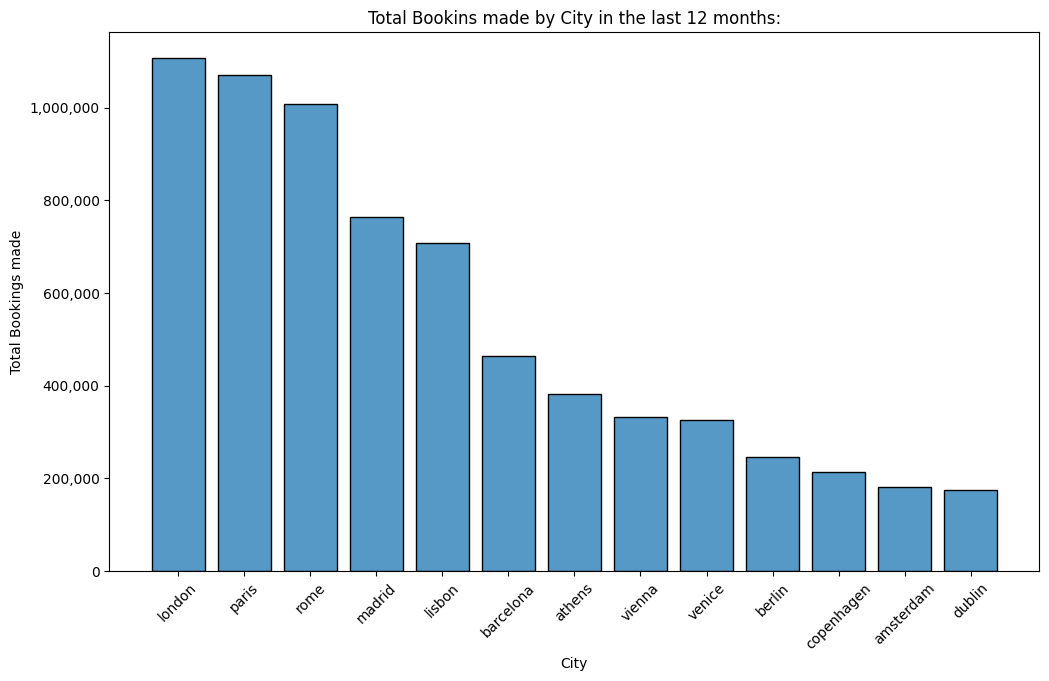

In [350]:
plt.figure(figsize=(12, 7))
plt.xlabel('City')
plt.ylabel('Total Bookings made')
plt.title('Total Bookins made by City in the last 12 months:')
plt.xticks(rotation=45)

# Use histplot to display the data with side-by-side bars for each city
ax = sns.histplot(
    data=total_bookings_per_city_df, 
    x="City", 
    weights="Total Bookings last 12 months", 
    shrink=0.8, 
)

plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))

plt.show()

### **Observations**

The data on total bookings made by city over the last 12 months aligns closely with the list of (Europe’s most visited cities)[https://thesavvybackpacker.com/most-visited-cities-in-europe/], reflecting the high tourism demand in these destinations. `London` leads with over 1.1 million bookings, followed by `Paris` with just over 1 million, and `Rome` closely behind. These top three cities are Europe’s most iconic travel hubs, drawing millions of visitors each year, so their high booking counts are very much in line with expectations.

`Madrid` and `Lisbon` show strong booking numbers, with Madrid approaching 764,000 bookings and Lisbon around 707,000. This supports their growing popularity as travel destinations, offering vibrant cultural scenes and a warm climate that attract tourists year-round. Cities like Barcelona, Athens, and Vienna also see significant bookings, each with over 300,000, reinforcing their status as essential stops on the European travel circuit.

`Venice`, despite its limited capacity and regulatory restrictions, registers over 326,000 bookings, which is consistent with its status as a high-demand destination for shorter stays or seasonal tourism. Meanwhile, cities with stricter rental regulations, like `Berlin`, `Copenhagen`, and `Amsterdam`, rank lower in total bookings, likely due to constraints on rental days and a more limited pool of available listings. Dublin has the fewest total bookings in this list, likely reflecting a smaller tourism base relative to the larger, more iconic cities.

Overall, this ranking closely mirrors what we would expect based on Europe’s most frequented cities, with London, Paris, and Rome dominating the list, followed by other prominent tourist destinations that collectively represent Europe’s rich cultural and historical appeal.

In [351]:
print('Total Nights Booked by City in the last 12 months:')
total_nights_per_city_df

Total Nights Booked by City in the last 12 months:


,City,Total Nights booked last 12 months
4,copenhagen,684556596.0
9,paris,531904650.0
10,rome,521402118.0
7,london,443447550.0
6,lisbon,280768116.0
8,madrid,266350506.0
2,barcelona,261629304.0
11,venice,193238412.0
1,athens,114946374.0
12,vienna,104252124.0


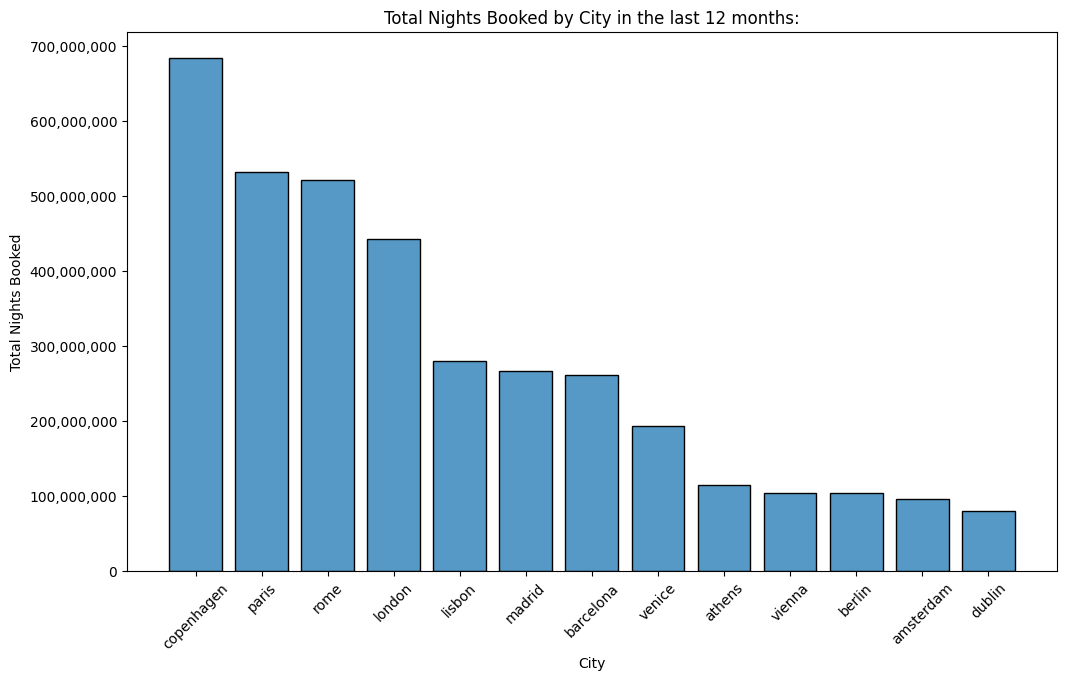

In [352]:
plt.figure(figsize=(12, 7))
plt.xlabel('City')
plt.ylabel('Total Nights Booked')
plt.title('Total Nights Booked by City in the last 12 months:')
plt.xticks(rotation=45)

# Use histplot to display the data with side-by-side bars for each city
ax = sns.histplot(
    data=total_nights_per_city_df, 
    x="City", 
    weights="Total Nights booked last 12 months", 
    shrink=0.8, 
)

plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))

plt.show()

### **Observations**
The data on total nights booked across various cities over the last 12 months presents some unexpected insights, especially in Copenhagen’s case. With a staggering 684 million nights booked, `Copenhagen` tops the list, a figure that seems unusually high given its lower average occupancy and smaller tourism volume compared to other top cities. This anomaly is likely due to our assumption that total bookings are roughly twice the number of reviews, a standard multiplier used in many data analyses. However, it’s possible that listings in Copenhagen attract a high number of reviews relative to actual bookings, perhaps due to the high quality or popularity of specific listings. This would inflate our calculated total nights booked, leading to the outsized result.

`Paris` and `Rome` follow with approximately 532 million and 521 million nights booked, respectively. Both cities are highly sought-after tourist destinations and feature a large number of Airbnb listings, so their high totals align well with expectations. London, `Lisbon`, and `Madrid` also see substantial bookings, further confirming their roles as prime European travel hotspots.

Other notable cities such as `Barcelona`, `Venice`, and `Athens`, though reporting fewer nights booked overall, still have significant totals that reflect their steady demand. Meanwhile, cities like `Vienna`, `Berlin`, `Amsterdam`, and `Dublin` show lower total nights booked, which is consistent with either stricter short-term rental regulations or a smaller share of the European tourism market.

In summary, while this data generally reflects travel patterns in popular European cities, Copenhagen’s exceptionally high total likely stems from the combined impact of our booking-to-review assumption and the unique review patterns of listings in that city. This result highlights how assumptions in data calculation can sometimes lead to unexpected findings, particularly in cases where review activity is disproportionately high relative to actual bookings.

### **General Observations**

The results from our analysis align well with expectations based on known tourism patterns. Major tourist destinations like London, Paris, and Rome lead in total bookings, reflecting their high visitor volume year-round. Conversely, cities with a smaller tourist base, such as Dublin and Vienna, report comparatively fewer bookings. This distribution of total bookings generally mirrors the relative popularity of each city among travelers in Europe.

However, Copenhagen stands out with an unusually high "Total Nights Booked" count. This discrepancy is likely a result of the method we used to estimate bookings, where we multiplied reviews by an assumed bookings-to-reviews ratio. For Copenhagen, this calculation might have led to an overestimation, potentially due to higher review rates per booking or unique characteristics of the Airbnb market in the city. Consequently, Copenhagen’s total appears disproportionate, suggesting that our approach may need adjustment for more accuracy in markets with distinct review dynamics.

Excluding Copenhagen, the overall trend of the data seems reasonable, aligning with established tourism statistics for these cities. This correlation with known travel patterns provides confidence in the accuracy of our analysis, despite the outlier. For more refined insights, accessing detailed, verified booking statistics from industry reports could help validate these estimates and further improve the model’s reliability.

## Analyzing the Relationship Between Occupancy Rates and the Period of the Year

We want to see which months hold the biggest occupany rates in all of the cities. We use for our analysis only the 12 last months for which we have data.

In [353]:
data['amsterdam']['calendar']

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,2818,2024-09-06,f,$69.00,0.0,3.0,1125.0
1,2818,2024-09-07,f,$69.00,0.0,3.0,1125.0
2,2818,2024-09-08,f,$69.00,0.0,3.0,1125.0
3,2818,2024-09-09,f,$69.00,0.0,3.0,1125.0
4,2818,2024-09-10,t,$69.00,0.0,3.0,1125.0
...,...,...,...,...,...,...,...
3525169,1238449706748135184,2025-09-01,t,$280.00,0.0,1.0,365.0
3525170,1238449706748135184,2025-09-02,t,$280.00,0.0,1.0,365.0
3525171,1238449706748135184,2025-09-03,t,$280.00,0.0,1.0,365.0
3525172,1238449706748135184,2025-09-04,t,$280.00,0.0,1.0,365.0


In [354]:
occupancy_rates_per_city = {}

for city, datasets in data.items():
    listings_df = datasets['listings']
    calendar_df = datasets['calendar']

    calendar_df['date'] = pd.to_datetime(calendar_df['date'])

    # Create additional columns for year and month for grouping
    calendar_df['year'] = calendar_df['date'].dt.year
    calendar_df['month'] = calendar_df['date'].dt.month

    calendar_df['available'] = calendar_df['available'].map({'t': 1, 'f': 0})

    monthly_availability = calendar_df.groupby(['listing_id', 'year', 'month']).agg(
        total_available_days=('available', 'sum'),
        total_days=('date', 'count')
    ).reset_index()

    # Calculate occupancy rate
    monthly_availability['occupancy_rate'] = (monthly_availability['total_available_days'] / monthly_availability['total_days']) * 100

    occupancy_rates_per_city[city] = monthly_availability


In [355]:
occupancy_rates_per_city['amsterdam']

,listing_id,year,month,total_available_days,total_days,occupancy_rate
0,2818,2024,9,3,25,12.000000
1,2818,2024,10,16,31,51.612903
2,2818,2024,11,28,30,93.333333
3,2818,2024,12,1,31,3.225806
4,2818,2025,1,25,31,80.645161
...,...,...,...,...,...,...
125549,1238449706748135184,2025,5,31,31,100.000000
125550,1238449706748135184,2025,6,30,30,100.000000
125551,1238449706748135184,2025,7,31,31,100.000000
125552,1238449706748135184,2025,8,31,31,100.000000


In [356]:
mean_occupancy_per_city = pd.DataFrame()

for city, occupancy_df in occupancy_rates_per_city.items():
    # Create a new datetime column from 'year' and 'month'
    occupancy_df['date'] = pd.to_datetime(occupancy_df['year'].astype(str) + '-' + occupancy_df['month'].astype(str), format='%Y-%m')
    
    mean_occupancy = occupancy_df.groupby('date')['occupancy_rate'].mean().reset_index()
    mean_occupancy['city'] = city
    
    mean_occupancy_per_city = pd.concat([mean_occupancy_per_city, mean_occupancy], ignore_index=True)

In [357]:
mean_occupancy_per_city

,date,occupancy_rate,city
0,2024-09-01,15.466891,amsterdam
1,2024-10-01,22.908637,amsterdam
2,2024-11-01,29.077794,amsterdam
3,2024-12-01,27.756698,amsterdam
4,2025-01-01,30.480498,amsterdam
...,...,...,...
164,2025-05-01,45.025052,vienna
165,2025-06-01,39.269705,vienna
166,2025-07-01,37.918239,vienna
167,2025-08-01,37.646882,vienna


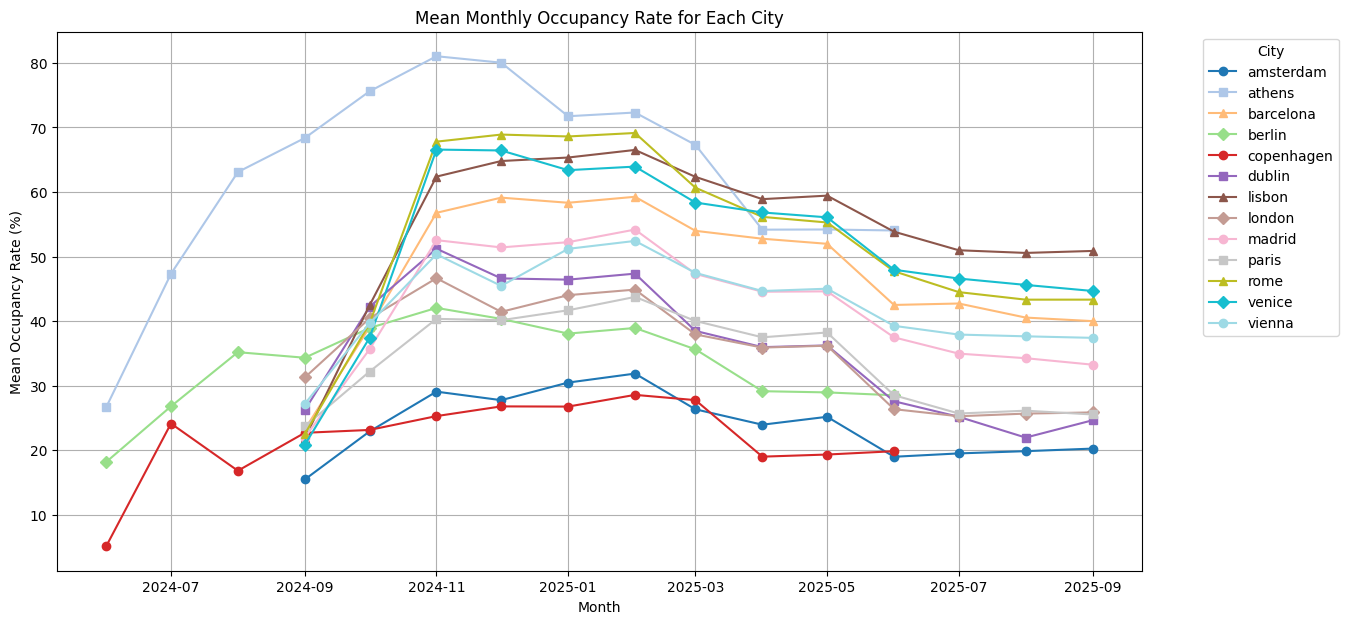

In [358]:
# Define a color map and line styles for better visibility
colors = plt.cm.tab20(np.linspace(0, 1, len(mean_occupancy_per_city['city'].unique())))
markers = ['o', 's', '^', 'D']

plt.figure(figsize=(14, 7))

# Iterate through each city and plot with distinct color, style, and marker
for i, city in enumerate(mean_occupancy_per_city['city'].unique()):
    city_data = mean_occupancy_per_city[mean_occupancy_per_city['city'] == city].sort_values('date')
    
    plt.plot(
        city_data['date'],
        city_data['occupancy_rate'],
        marker=markers[i % len(markers)],
        color=colors[i],
        label=city
    )

plt.title('Mean Monthly Occupancy Rate for Each City')
plt.xlabel('Month')
plt.ylabel('Mean Occupancy Rate (%)')
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)


### **Observations**
This plot shows the mean monthly occupancy rate (%) for various cities over a period from around June 2024 to September 2025. Here are some observations:

- `Seasonal Peaks`: Most cities experience a peak in occupancy rates around mid-2024 (June to August), likely reflecting increased travel during the summer months in Europe. After the peak, the occupancy rate gradually decreases across cities.

- `Consistent Leaders`: Cities like Athens and Lisbon maintain relatively high occupancy rates throughout the year, indicating steady demand, possibly due to their appeal as year-round destinations with milder climates.

- `Strong Decline Post-Summer` There is a noticeable decline in occupancy rates for all cities after the summer peak, dropping more steeply around the winter months and into the early months of 2025.

- `Variance Across Cities`: Some cities, like Copenhagen and Amsterdam, exhibit lower occupancy rates overall compared to others like Athens and Lisbon. Amsterdam's occupancy may be influenced by local regulations on short-term rentals, which can limit availability. Similarly, Berlin has its own set of restrictions that could affect the number of listings and, consequently, occupancy rates.

- `Relative Stability in Some Cities`: Cities like Paris and Madrid show smaller fluctuations in occupancy rates compared to others. These cities might be attracting tourists more consistently throughout the year, possibly due to a combination of business and leisure tourism. However, the occupancy rate in Paris is generally lower relative to other cities due to its larger number of listings, which spreads out the demand.

- `End-of-Year Decline`: Towards the end of the observed period (mid-to-late 2025), most cities show a decline in occupancy rates, which could either indicate seasonal patterns or possibly external factors affecting travel during that time.

- `Upward Trend in 2025`: Overall, it can be observed that Airbnb listings have shown an upward trend in 2025 compared to 2024. 

- `Reliability of Data`: We cannot fully rely on this data since many of the dates are in the future, and various factors, such as cancellations or changes in bookings, could significantly alter occupancy rates.

- `Influence of Tourist Capacity`: The tourist capacity of each city greatly influences occupancy levels. For example, in Paris, higher availability leads to more competition for bookings, potentially resulting in lower occupancy rates.

## Analyzing the Relationship Between Occupancy Rates and Distance from the Touristic Center
We want to see the distance from the City Center that visitors tend to prefer to stay on each city.

### Tourist Centers of Major Cities

| City        | Tourist Center Coordinates      | What is there? Why is it the center?                                            |
|-------------|---------------------------------|-------------------------------------------------------------------------------|
| Amsterdam   | (52.3740, 4.8897)               | The Dam Square area, known for major attractions like the Royal Palace and National Monument. It's the cultural and historical heart of Amsterdam. |
| Athens      | (37.9838, 23.7275)              | Syntagma Square, located near the Acropolis, is the center for tourists visiting historical landmarks. It’s a key hub for culture and transportation. |
| Barcelona   | (41.3851, 2.1734)               | The area around Plaça de Catalunya, close to La Rambla and other major attractions. It is a popular meeting point and transport hub in the city. |
| Berlin      | (52.5200, 13.4050)              | Brandenburg Gate, one of Berlin's most iconic landmarks, located near the city center, symbolizing reunification and a popular tourist attraction. |
| Copenhagen  | (55.6761, 12.5683)              | The City Hall Square (Rådhuspladsen), a central point for tourists, near Tivoli Gardens and the main shopping district. |
| Dublin      | (53.3498, -6.2603)              | The area around Trinity College, the heart of Dublin, close to major landmarks like Dublin Castle and St. Stephen's Green. |
| Lisbon      | (38.7223, -9.1393)              | Praça do Comércio, a grand square by the riverfront, is the historical and cultural center of Lisbon, with views of the iconic 25 de Abril Bridge. |
| London      | (51.5074, -0.1278)              | Trafalgar Square, surrounded by key landmarks such as the National Gallery, Big Ben, and the Houses of Parliament, is a focal point for tourists in London. |
| Madrid      | (40.4168, -3.7038)              | Puerta del Sol, a bustling square that serves as a central point in Madrid, near historic sites like the Royal Palace and Plaza Mayor. |
| Paris       | (48.8566, 2.3522)               | Notre-Dame Cathedral and the Île de la Cité, a historic center of Paris, known for its landmarks and as a hub of cultural activities. |
| Rome        | (41.9028, 12.4964)              | Piazza Venezia, near the Roman Forum and Colosseum, is a central hub of Rome, historically significant and a major tourist destination. |
| Venice      | (45.4408, 12.3155)              | The Rialto Bridge area, located on the Grand Canal, is the cultural and historical heart of Venice, near iconic attractions and vibrant markets. |
| Vienna      | (48.2082, 16.3738)              | Stephansplatz, home to St. Stephen's Cathedral, is the heart of Vienna's cultural and historical district, surrounded by key attractions. |

In [359]:
# We store the approximate tourist center for all our cities
tourist_centers = {
    'amsterdam': (52.3740, 4.8897),
    'athens': (37.9838, 23.7275),
    'barcelona': (41.3851, 2.1734),
    'berlin': (52.5200, 13.4050),
    'copenhagen': (55.6761, 12.5683),
    'dublin': (53.3498, -6.2603),
    'lisbon': (38.7223, -9.1393),
    'london': (51.5074, -0.1278),
    'madrid': (40.4168, -3.7038),
    'paris': (48.8566, 2.3522),
    'rome': (41.9028, 12.4964),
    'venice': (45.4408, 12.3155),
    'vienna': (48.2082, 16.3738)
}

In [360]:
def calc_distance(coord1, coord2):
    """
    Calculate a simple approximation of the distance between two points on the Earth's surface
    specified in decimal degrees (latitude, longitude).

    Parameters:
    coord1 (tuple): The (latitude, longitude) of the first location.
    coord2 (tuple): The (latitude, longitude) of the second location.

    Returns:
    float: The distance in meters between the two coordinates.
    """
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    lat_distance = (lat2 - lat1) * 111139  # Approximate meters per degree latitude
    lon_distance = (lon2 - lon1) * 85000 * math.cos(math.radians((lat1 + lat2) / 2))  # Approximate meters per degree longitude
    
    # Use Pythagorean theorem to calculate distance
    return (lat_distance**2 + lon_distance**2)**0.5

In [361]:
for city, datasets in data.items():
    listings_df = datasets['listings']  # Assuming this is a pandas DataFrame
    for index, listing in listings_df.iterrows():
        # Create a tuple for listing coordinates
        listing_coordinates = (listing['latitude'], listing['longitude'])
        
        # Calculate the distance using the appropriate function
        distance = calc_distance(listing_coordinates, tourist_centers[city])
        
        # Use .loc to save the distance back to the DataFrame
        listings_df.loc[index, 'distance_from_center'] = distance

In [362]:
def distance_group(distance):
    if distance < 1000:
        return '0-1 km'
    elif distance < 2000 and distance >= 1000:
        return '1-2 km'
    elif distance < 3000 and distance >= 2000:
        return '2-3 km'
    elif distance < 4000 and distance >= 3000:
        return '3-4 km'
    elif distance < 5000 and distance >= 4000:
        return '4-5 km'
    elif distance < 6000 and distance >= 5000:
        return '5-6 km'
    elif distance < 7000 and distance >= 6000:
        return '6-7 km'
    elif distance < 8000 and distance >= 7000:
        return '7-8 km'
    elif distance < 9000 and distance >= 8000:
        return '8-9 km'
    else:
        return '9+km'

In [363]:
for city, dataset in data.items():  
  # apply the funciton to the distance_from_center column for each entry
  dataset['listings']['distance_group'] = dataset['listings']['distance_from_center'].apply(distance_group)

In [364]:
mean_occupancy_by_distance = pd.DataFrame()

for city, occupancy_df in occupancy_rates_per_city.items():
    # Merge occupancy data with the listings to get distance_group
    merged_df = occupancy_df.merge(data[city]['listings'][['id', 'distance_group']], left_on='listing_id', right_on='id', how='left')
    
    # Group by distance_group and calculate the mean occupancy rate
    mean_occupancy = merged_df.groupby('distance_group')['occupancy_rate'].mean().reset_index()
    mean_occupancy['city'] = city  # Add city name for identification
    
    mean_occupancy_by_distance = pd.concat([mean_occupancy_by_distance, mean_occupancy], ignore_index=True)

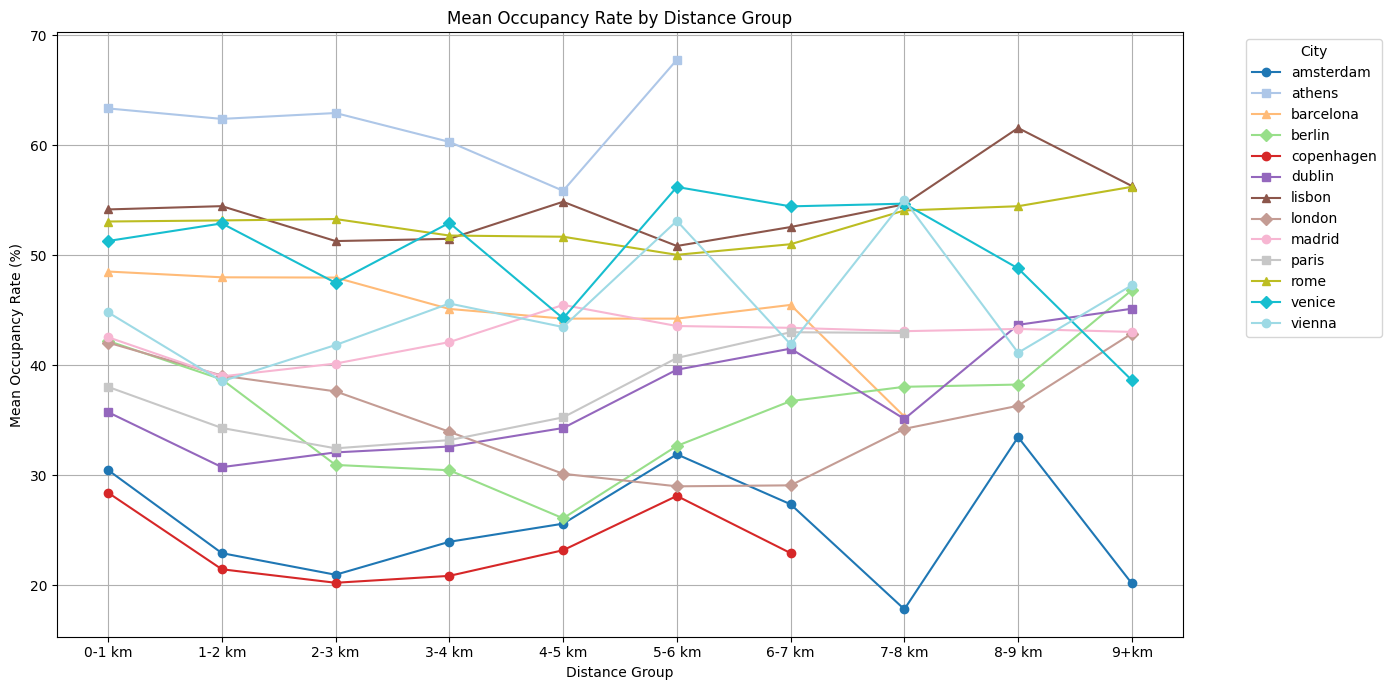

In [365]:
# Define a color map and line styles for better visibility
colors = plt.cm.tab20(np.linspace(0, 1, len(mean_occupancy_by_distance['city'].unique())))
markers = ['o', 's', '^', 'D']

plt.figure(figsize=(14, 7))

for i, city in enumerate(mean_occupancy_by_distance['city'].unique()):
    city_data = mean_occupancy_by_distance[mean_occupancy_by_distance['city'] == city]
    
    plt.plot(
        city_data['distance_group'],
        city_data['occupancy_rate'],
        marker=markers[i % len(markers)],
        color=colors[i],
        label=city
    )

plt.title('Mean Occupancy Rate by Distance Group')
plt.xlabel('Distance Group')
plt.ylabel('Mean Occupancy Rate (%)')
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### **Observations**
- `High Central Demand with Gradual Decrease (Amsterdam, Barcelona, Paris, Rome, Madrid)`:

    These cities have strong appeal in central areas due to iconic attractions (e.g., Amsterdam’s nightlife, Barcelona's Gothic Quarter, Paris’s Latin Quarter). However, high costs, congestion, and occasional safety concerns encourage some travelers to stay slightly farther out.

- `Decentralized Popularity Across Neighborhoods (Berlin, London, Vienna)`:

    In cities with decentralized layouts, occupancy is consistent across distances. Neighborhoods like Berlin’s Kreuzberg, London’s Camden, and Vienna’s suburbs offer attractive, accessible alternatives to the core, reflecting both diverse local culture and effective public transport.

- `Preference for Suburban or Outlying Areas (Athens, Dublin, Copenhagen)`:

    Cities with high accommodation costs and limited central space see more demand in outer areas. In Dublin, Temple Bar’s nightlife pushes visitors to quieter residential neighborhoods. Similarly, in Athens, congestion in central areas makes suburbs more appealing.

- `Compact and Popular Central Areas (Lisbon, Venice)`:

    These cities have high demand in central tourist zones due to compact layouts and proximity to attractions (e.g., Baixa and Chiado in Lisbon). However, challenges like steep hills or limited central space sometimes drive visitors toward quieter outer areas in Venice or Lisbon’s outskirts.

- `Gradual Suburban Demand Rise and Potential for New Trends (Athens, Dublin, Vienna, Berlin)`:

    In cities with evolving suburban demand, Airbnb usage may extend beyond tourist centers as new trends, like digital nomads, emerge. These travelers often prefer residential or suburban areas over historical centers, blending more with local lifestyles.

- `Presence of “Bad Neighborhoods” Near Tourist Centers`:

    In many cities, we observe the presence of a "bad neighborhood" near the tourist center. Although it is close to the central tourist area, it has low demand.

- `Fluctuations in Wealthier vs. Less Developed Cities`:

    In wealthy metropolises, the tourist market shows smooth fluctuations between the central tourist area, poorer neighborhoods, and better suburban neighborhoods (e.g., Amsterdam, Copenhagen). The opposite is observed in less developed cities, like Greece and Lisbon, where these differences are more pronounced.

- `Rising Suburban Demand and the Influence of Digital Nomads`:

    In most metropolises (if we had more data), the demand for areas further from the central tourist area (usually the suburbs) seems to increase more sharply. This may suggest that the future of Airbnb could extend beyond historic tourist cities (e.g., Athens, Dublin, Vienna, Berlin). This likely means that new demand factors are emerging, such as digital nomads, who may prefer to stay in suburban areas like locals rather than in historic tourist centers.

- `Price Fluctuations in Highly Touristic Areas`:

    In places like Venice, the sharp and frequent price fluctuations observed on the curve likely stem from the highly touristic and expansive nature of the area, rather than a metropolis with a single historic center and distinct suburbs. In these cases, there isn’t a clear trend for Airbnb usage as a stable accommodation or residence. Consequently, in such areas, trends like those we mentioned earlier—such as digital nomads seeking longer-term stays—are less likely to appear.

## Visualisation

Check the visualisations at the right of <https://insideairbnb.com/athens/>. Replicate these visualisations. Make the selection interactive, i.e., the user should be able to select a city from a dropdown box and see the corresponding visualisations. You can use any visualisation library. A good visualisation library that we did not have time to explore in the lectures but is worth your attention and comes with interactive features is [Vega-Altair]( https://altair-viz.github.io/user_guide/interactions.html).

In [366]:
room_type_count_df = {}

for city, datasets in data.items():
  #  Calculate the percentage of listings per room type
  temp_df = datasets['listings']['room_type'].value_counts(normalize=True) * 100

  # Convert the Series to a DataFrame
  temp_df = temp_df.reset_index()
  temp_df.columns = ['room_type', 'listings']

  room_type_count_df[city] = temp_df

In [367]:
def plot_room_type(city, ax):
  sns.barplot(
    y=room_type_count_df[city]['room_type'], 
    x=room_type_count_df[city]['listings'], 
    palette='muted', 
    hue=room_type_count_df[city]['room_type'],
    ax=ax)

  plt.xlabel('room_type')
  plt.ylabel('listings')
  plt.title('Percentage of Listings by Room Type in Athens')


In [368]:
def occupancy_group(days):
    if days == 0:
        return '0'
    elif 1 <= days <= 30:
        return '1-30'
    elif 31 <= days <= 60:
        return '31-60'
    elif 61 <= days <= 90:
        return '61-90'
    elif 91 <= days <= 120:
        return '91-120'
    elif 121 <= days <= 150:
        return '121-150'
    elif 151 <= days <= 180:
        return '151-180'
    elif 181 <= days <= 210:
        return '181-210'
    elif 211 <= days <= 240:
        return '211-240'
    else:
        return '241-255+'

In [369]:
# Apply the function to the total_nights_booked column of each entry
for city, dataset in data.items():  
  dataset['listings']['occupancy_group'] = dataset['listings']['total_nights_booked'].apply(occupancy_group)

In [370]:
activity_df = {}

for city, datasets in data.items():
  #  Calculate the percentage of listings per room type
  temp_df = datasets['listings']['occupancy_group'].value_counts()

  # Apply custom order for the plot later on
  custom_order = [
    '0', 
    '1-30', 
    '31-60', 
    '61-90', 
    '91-120', 
    '121-150', 
    '151-180', 
    '181-210', 
    '211-240', 
    '241-255+'
  ]
  temp_df = temp_df.reindex(custom_order)

  # Convert the Series to a DataFrame
  temp_df = temp_df.reset_index()
  temp_df.columns = ['occupancy_group', 'listings']

  activity_df[city] = temp_df

In [371]:
def plot_activity(city, ax):
  sns.barplot(
    x=activity_df[city]['occupancy_group'], 
    y=activity_df[city]['listings'],
    ax=ax,
    width=0.5
    )

  plt.xlabel('occupancy (last 12 months)')
  plt.ylabel('listings')
  plt.title('Percentage of Listings by Room Type in Athens')

In [372]:
average_nights_booked = {}

for city, datasets in data.items():
  average_nights_booked[city] = datasets['listings']['total_nights_booked'].mean()

In [373]:
price_per_night = {}

for city, datasets in data.items():
  price_per_night[city] = datasets['listings']['price'].mean()

In [374]:
average_income = {}

for city, datasets in data.items():
  average_income[city] = datasets['listings']['income_per_listing'].mean()

In [375]:
short_term_rentals_df = {}

# Loop through the cities and update the minimum_nights column
for city, dataset in data.items():
    dataset['listings'].loc[dataset['listings']['minimum_nights'] >= 35, 'minimum_nights'] = 35

    temp_df = dataset['listings']['minimum_nights'].value_counts().sort_index()
    
    # Convert the Series to a DataFrame
    temp_df = temp_df.reset_index()
    temp_df.columns = ['minimum_nights', 'listings']

    short_term_rentals_df[city] = temp_df


In [376]:
def plot_short_term_rentals(city, ax):
    sns.barplot(
        x=short_term_rentals_df[city]['minimum_nights'], 
        y=short_term_rentals_df[city]['listings'],
        ax=ax
    )

    # Customize the x-axis to display "35+" next to 35
    labels = [str(x) if x != 35 else '35+' for x in short_term_rentals_df[city]['minimum_nights']]
    plt.xticks(ticks=range(len(labels)), labels=labels)

    # Customize the plot
    plt.xlabel('Minimum Nights')
    plt.ylabel('Listings')
    plt.title('Percentage of Listings by Minimum Nights')


In [377]:
listings_per_host_df = {}

for city, dataset in data.items():

    # Calculate the value counts of minimum_nights
    temp_df = dataset['listings'].groupby('host_id').size()

    # Replace any value over 10 with 10 for better visuals
    temp_df = temp_df.apply(lambda x: min(x, 10))

    temp_df = temp_df.value_counts().sort_index()

    # Convert the Series to a DataFrame
    temp_df = temp_df.reset_index()
    temp_df.columns = ['host_id', 'listings']

    listings_per_host_df[city] = temp_df

In [378]:
def plot_listings_per_host(city, ax):
    data = listings_per_host_df[city]

    bar_positions = range(len(data['host_id']))
    bar_width = 0.5 

    # Create the bar plot with custom spacing
    ax.bar(
        bar_positions, 
        data['listings'], 
        width=bar_width, 
    )
    # Customize the x-axis to display "35+" next to 35
    labels = [str(x) if x != 10 else '10+' for x in listings_per_host_df[city]['host_id']]
    plt.xticks(ticks=range(len(labels)), labels=labels)

    # Customize the plot
    plt.xlabel('listings per host')
    plt.ylabel('listings')
    plt.title('Listings per host')


In [379]:
top_hosts = {}

for city, dataset in data.items():
    # Group by host_name and count occurrences of each room type
    temp_df = dataset['listings'].groupby('host_name')['room_type'].value_counts().unstack(fill_value=0).reset_index()

    # Rename columns for clarity
    temp_df.columns.name = None  # Remove the column name
    temp_df = temp_df.rename(columns={
        'Entire home/apt': '#Entire home/apts',
        'Private room': '#Private rooms',
        'Shared room': '#Shared rooms',
        'Hotel room': '#Hotel Rooms'
    })

    # Count the total number of listings for each host
    temp_df['#Listings'] = temp_df[['#Entire home/apts', '#Private rooms', '#Shared rooms', '#Hotel Rooms']].sum(axis=1)

    # Sort by the number of listings
    temp_df = temp_df.sort_values(by='#Listings', ascending=False)
    
    # keep the first 50
    temp_df = temp_df.head(50)

    top_hosts[city] = temp_df


In [380]:
def plot_dataframe(city, ax):

    df = data[city]
    ax.axis('off')  # Turn off the axis for the table
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center',
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(df.columns))))

In [381]:
# Dropdown widget for city selection
city_selector = widgets.Dropdown(
    options=list(data.keys()),
    value='athens',
    description='Cities:',
)

# Function to update plots based on the selected city
def update_plot(city):
    fig, axes = plt.subplots(4, 1, figsize=(10, 18))  # 4 rows, 1 column

    # Plot the graphs 
    plot_room_type(city, axes[0])
    plot_activity(city, axes[1])
    plot_short_term_rentals(city, axes[2])
    plot_listings_per_host(city, axes[3])

    plt.tight_layout()
    plt.show()

    # Display the DataFrame as a styled table
    styled_table = (
        top_hosts[city]
        .style
        .set_table_styles(
            [
                {'selector': 'thead th', 'props': [('background-color', '#f4f4f4'), ('font-weight', 'bold')]},
                {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#f9f9f9')]},
                {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#ffffff')]},
            ]
        )
        .set_caption("Top Hosts in Selected City")
        .set_properties(**{'text-align': 'center', 'border': '1px solid black', 'padding': '5px'})
    )
    display(styled_table)

widgets.interactive(update_plot, city=city_selector)

interactive(children=(Dropdown(description='Cities:', index=1, options=('amsterdam', 'athens', 'barcelona', 'b…

### **Observations**
The results would be much more visually appealing if we had utilized JavaScript for this part. However, we’re still close to our goal, which is having the tab on the website, along with the plots that dynamically update based on the selected city, providing real-time information.

## Submission Instructions

You must submit your assignment as a Jupyter notebook that will contain the full code and documentation of how you solved the questions. The Jupyter notebook must be fully replicable: that is, somebody reading it must be able to do exactly what you did and obtain the same results.

The documentation must be at the level where somebody that has some knowledge of Python can understand exactly what you are doing and why. Your output must be as user-friendly as possible. That means that your output tables should not include zillions of columns that are not needed for your analysis.

## Honor Code

You understand that this is an individual assignment, and as such you must carry it out alone. You may seek help on the Internet, on ChatGPT/Gemini/etc., by Googling or searching in StackOverflow for general questions pertaining to the use of Python and pandas libraries and idioms. However, it is not right to ask direct questions that relate to the assignment and where people will actually solve your problem by answering them. You may discuss with your colleagues in order to better understand the questions, if they are not clear enough, but you should not ask them to share their answers with you, or to help you by giving specific advice.